In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
def get_minutes(time_col: str) -> int:
    """
    Get the time lenght of a movie or tv show in minutes.

    - Check whether is a digit.
    - In case it is not a digit:
        - If 'Season' is defined as time, return None.
        - If 'h' is included, transform hours into minutes and add up values.
        - If 'm' is included, remove 'm'.

    Parameters
    ----------
    time_col : str
        Movie duration description.

    Returns
    -------
    int
        Movie duration in minutes.

    """
    if time_col.isdigit():
        return int(time_col)
    elif 'Season' in time_col:
        return None
    else:
        if 'h' in time_col:
            time_col = time_col.replace('m','').split('h')
            hours_to_min = int(time_col[0])*60
            minutes = int(time_col[-1])
            total_minutes = hours_to_min + minutes
            return total_minutes
        else:
            return int(time_col.replace('m',''))

# About Dataset
Netflix is one of the most popular media and video streaming platforms, boasting over 200 million subscribers globally as of mid-2021. This tabular dataset consists of listings of all the movies and TV shows available on Netflix, along with details such as cast, directors, ratings, release year, duration, etc.

# Load Data

In [3]:
df = pd.read_csv('netflix_full.csv')

# DataFrame wrangling

Factorize and create new columns to obtain cleaner data.

In [4]:
df = df\
.assign(starring=lambda df:
        df['starring'].apply(lambda x: x.split(',')))\
.assign(genres=lambda df:
        df['genres'].fillna('').apply(lambda x: x.split(',')))\
.assign(creator=lambda df:
        df['creator'].fillna(''))\
.assign(time=lambda df:
        df['time'].apply(lambda x: x.replace('min', ' ').strip(' ')))\
.assign(time_in_minutes=lambda df:
          df['time'].apply(get_minutes))\
.assign(starring_pair=lambda df: df['starring'].apply(
        lambda starring: [(actor.strip(), sub_actor.strip()) for actor in starring for sub_actor in starring if actor.strip() != sub_actor.strip()]))

Display information about Movie and TV show distribution in Netflix's library

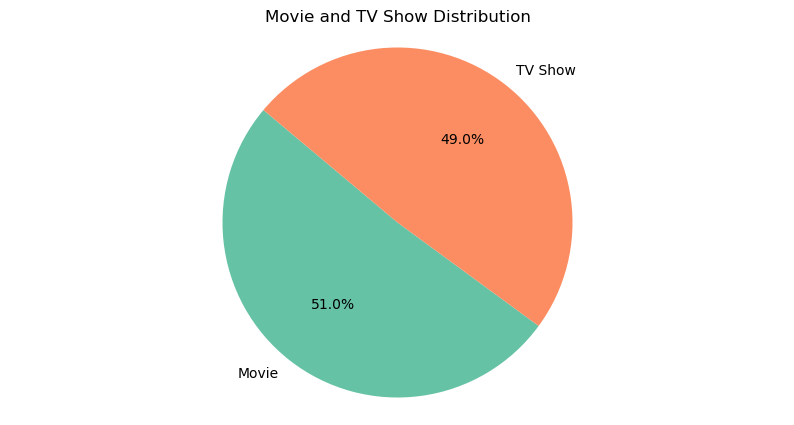

In [5]:
# get counts
type_counts = df['type'].value_counts()

# define figure size
plt.figure(figsize=(10, 5))

# define Seaborn color palette to use 
palette_color = sns.color_palette('Set2')

# create pie chart
plt.pie(type_counts, labels=type_counts.index, 
       autopct='%1.1f%%', startangle=140, colors=palette_color)
plt.title('Movie and TV Show Distribution')
plt.axis('equal')
plt.show()

# Actors

Display information about the top 5 actors appearing each year

In [6]:
# Convert list of actors, into one for per actor appearing in starring column
actors_df = df.explode('starring')

In [7]:
top_actors_5_per_year = actors_df['starring']\
    .groupby(df['year'])\
    .value_counts()\
    .groupby(level=0, group_keys=False)\
    .head(5)\
    .to_frame('counts')\
    .reset_index()\
    .style.hide()
top_actors_5_per_year

year,starring,counts
2012,Chris Hemsworth,2
2012,Alexander Skarsgård,1
2012,Alia Bhatt,1
2012,Amy Johnson,1
2012,Andrea Aboagye,1
2013,Andy Lau,3
2013,Marina Inoue,2
2013,Yui Ishikawa,2
2013,Jang Hyuk,2
2013,Yuki Kaji,2


Show the top 25 actors with the most appearances in the Netflix library.

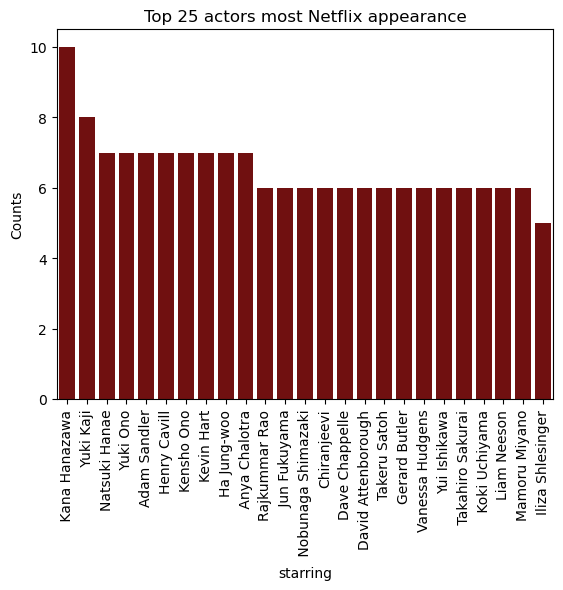

In [8]:
# groupby actors, count appearence, remove actors which have not appeared more than once
actors_ocurrence = actors_df\
.groupby(['starring'])\
.agg({'starring': 'count'})\
.rename(columns={'starring':'Counts'})\
.reset_index()\
.sort_values(by=['Counts'], ascending=False)\
.reset_index(drop=True)\
.loc[lambda x: x['Counts'] > 1]\
.iloc[:25]

# create bar chart
ax = sns.barplot(data=actors_ocurrence, x='starring', y='Counts', color='maroon')
ax.tick_params(axis='x', rotation=90)
ax.set_title("Top 25 actors most Netflix appearance")
plt.show()

Display info about the common pair of actors in Netflix.

In [9]:
# Convert each pair of actor into a single row
most_common_pairs_actors = df.explode('starring_pair').reset_index(drop=True)

# Group by pair and count occurences
pairs_actors = most_common_pairs_actors.groupby('starring_pair')\
                                .agg({'starring_pair':'count'})\
                                .rename(columns={'starring_pair': 'Counts'})\
                                .reset_index()\
                                .sort_values(by='Counts', ascending=False)\
                                .reset_index(drop=True)\
                                .head(20)
# Save the list of actors
pairs_actors_lst = pairs_actors['starring_pair'].to_list()

# Remove tuple for better readability
pairs_actors = pairs_actors.assign(starring_pair=lambda df:
                                   df['starring_pair'].apply(lambda x: ', '.join(x)))\
.style.hide()
pairs_actors

starring_pair,Counts
"Anya Chalotra, Henry Cavill",7
"Henry Cavill, Anya Chalotra",7
"Henry Cavill, Freya Allan",5
"Yuki Ono, Kensho Ono",5
"Anya Chalotra, Freya Allan",5
"Kensho Ono, Yuki Ono",5
"Freya Allan, Anya Chalotra",5
"Freya Allan, Henry Cavill",5
"Sydney Park, Amber Frank",4
"Sydney Park, Bailey Gambertoglio",4


In [10]:
# Display dataframe containing data from the most common pairs of actors

overview_pair_actors = most_common_pairs_actors[most_common_pairs_actors['starring_pair'].isin(pairs_actors_lst)]\
.filter(items=['starring_pair', 'name', 'year'])\
.reset_index(drop=True)\
.assign(starring_pair=lambda df:
       df['starring_pair'].apply(lambda x: ','.join(x)))\
.style.hide()
overview_pair_actors

starring_pair,name,year
"Henry Cavill,Anya Chalotra",The Characters of the Continent,2021
"Henry Cavill,Freya Allan",The Characters of the Continent,2021
"Anya Chalotra,Henry Cavill",The Characters of the Continent,2021
"Anya Chalotra,Freya Allan",The Characters of the Continent,2021
"Freya Allan,Henry Cavill",The Characters of the Continent,2021
"Freya Allan,Anya Chalotra",The Characters of the Continent,2021
"Emi Takei,Takeru Satoh",Rurouni Kenshin: Origins,2012
"Emi Takei,Takeru Satoh",Rurouni Kenshin: The Final,2021
"Emi Takei,Takeru Satoh",Rurouni Kenshin: The Legend Ends,2014
"Emi Takei,Takeru Satoh",Rurouni Kenshin: Kyoto Inferno,2014


# Genres

Display information about genres with the highest number of movies.

In [11]:
# Explode genres as there might be more than one genre in a movie or tv show
genre_df = df.explode('genres')\
.assign(genres=lambda x:
      x['genres'].apply(lambda x: x.strip()))

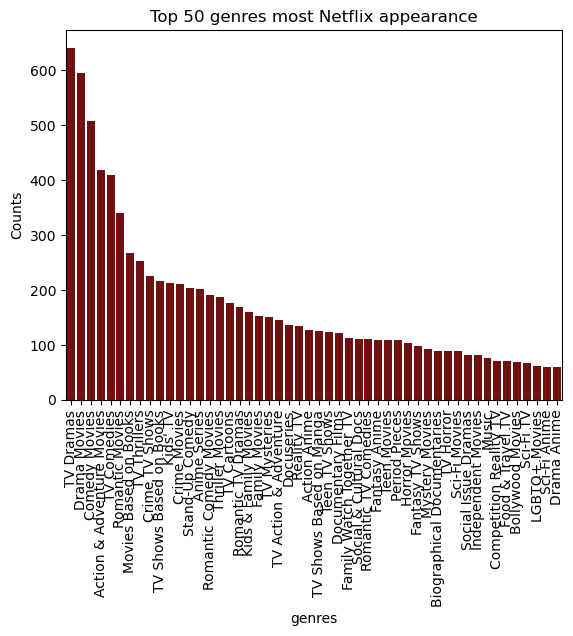

In [12]:
# Group by genre
genres_count = genre_df\
             .groupby(['genres'])\
             .size()\
             .reset_index()\
             .rename(columns={0:'Counts'})\
             .sort_values(by=['Counts'], ascending=False)\
             .reset_index(drop=True)\
             .loc[lambda x: x['Counts'] > 1]\
             .iloc[:50]
# plotting data on chart
ax = sns.barplot(data=genres_count, x='genres', y='Counts', color='maroon')
ax.tick_params(axis='x', rotation=90)
ax.set_title("Top 50 genres most Netflix appearance")
plt.show()

Overview of the top 5 genres per year

In [13]:
# Get the top 5 genre for each year
top_5_genre_per_year = genre_df['genres']\
    .groupby(df['year'])\
    .value_counts()\
    .groupby(level=0, group_keys=False)\
    .head(5)\
    .to_frame('counts')\
    .reset_index()

# Count movie or show appearence in such genre for each year
top_5_genre_per_year = top_5_genre_per_year.pivot(index='genres', columns='year', values='counts')\
.fillna(0)\
.reset_index()\
.assign(Total=lambda df:
       df.sum(numeric_only=True, axis=1))

# Add Grand total row
grand_total_row = top_5_genre_per_year.sum(numeric_only=True).to_frame().T
grand_total_row[top_5_genre_per_year.columns[0]] = 'Grand total'
top_5_genre_per_year = pd.concat([top_5_genre_per_year, grand_total_row], ignore_index=True)
top_5_genre_per_year

year,genres,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,Total
0,Action & Adventure Movies,15.0,17.0,27.0,16.0,36.0,33.0,41.0,0.0,0.0,58.0,70.0,40.0,353.0
1,Comedy Movies,9.0,15.0,18.0,18.0,28.0,35.0,48.0,49.0,68.0,68.0,101.0,51.0,508.0
2,Drama Movies,16.0,15.0,18.0,15.0,24.0,43.0,87.0,61.0,68.0,84.0,105.0,59.0,595.0
3,Kids' TV,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
4,Movies Based on Books,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
5,Romantic Movies,8.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,0.0,64.0,40.0,153.0
6,TV Comedies,0.0,0.0,13.0,20.0,24.0,35.0,43.0,58.0,58.0,60.0,0.0,0.0,311.0
7,TV Dramas,0.0,11.0,12.0,19.0,34.0,54.0,67.0,97.0,100.0,79.0,94.0,67.0,634.0
8,TV Shows Based on Books,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0.0,0.0,0.0,44.0
9,Grand total,55.0,68.0,88.0,88.0,146.0,200.0,286.0,306.0,338.0,349.0,434.0,257.0,2615.0


# Movies

Display information about the longest and shortest movie & tv show.

In [14]:
longest_movie = df[(df['type'] == 'Movie') & (df['time_in_minutes'] == df[df['type'] == 'Movie']['time_in_minutes'].max())]['name'].item()
shortest_movie = df[(df['type'] == 'Movie') & (df['time_in_minutes'] == df[df['type'] == 'Movie']['time_in_minutes'].min())]['name'].item()
longest_tv_show = df[(df['type'] == 'TV Show') & (df['time_in_minutes'] == df[df['type'] == 'TV Show']['time_in_minutes'].max())]['name'].item()
shortest_tv_show = df[(df['type'] == 'TV Show') & (df['time_in_minutes'] == df[df['type'] == 'TV Show']['time_in_minutes'].min())]['name'].item()

In [15]:
print(f'Longest movie available in Netflix is: {longest_movie}')
print(f'Shortest movie available in Netflix is: {shortest_movie}\n')
print(f'Longest TV show available in Netflix is: {longest_tv_show}')
print(f'Shortest TV show available in Netflix is: {shortest_tv_show}')

Longest movie available in Netflix is: The Irishman
Shortest movie available in Netflix is: The Characters of the Continent

Longest TV show available in Netflix is: Moo 2
Shortest TV show available in Netflix is: A StoryBots Space Adventure


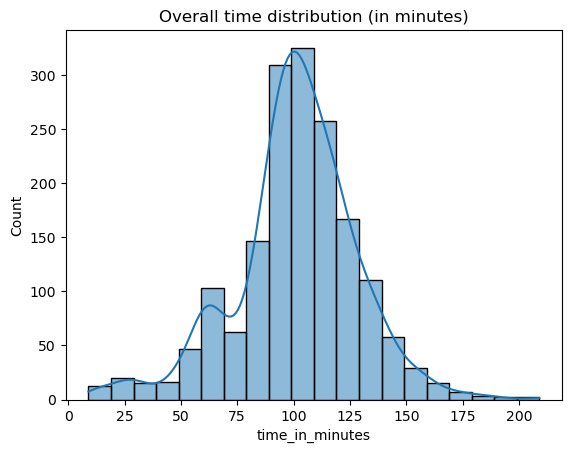

In [16]:
# plotting data on chart
sns.histplot(df['time_in_minutes'], bins=20, kde=True)
plt.title('Overall time distribution (in minutes)')
plt.show()

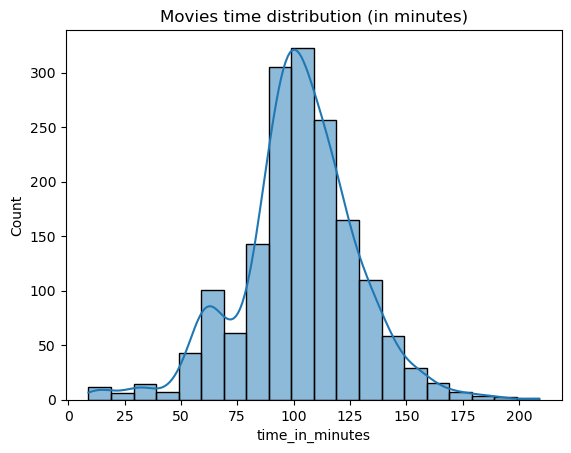

In [17]:
# set up data
movies_lenght = df[df['type'] == 'Movie']

# plotting data on chart
sns.histplot(movies_lenght['time_in_minutes'], bins=20, kde=True)
plt.title('Movies time distribution (in minutes)')
plt.show()

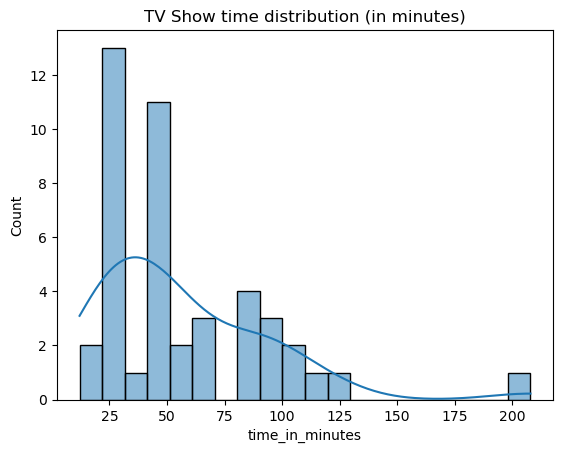

In [18]:
# set up data
tv_show_lenght = df[df['type'] == 'TV Show']

# plotting data on chart
sns.histplot(tv_show_lenght['time_in_minutes'], bins=20, kde=True)
plt.title('TV Show time distribution (in minutes)')
plt.show()

Display information about the amount of movies in the Netflix library per year

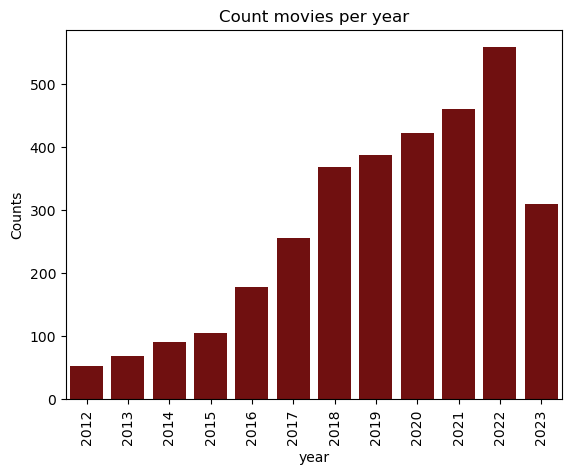

In [19]:
# set up data
movies_per_year = df.groupby('year').agg({'year': 'count'}).rename(columns={'year': 'Counts'}).reset_index()

# plotting data on chart
ax = sns.barplot(data=movies_per_year, x='year', y='Counts', color='maroon')
ax.tick_params(axis='x', rotation=90)
ax.set_title("Count movies per year")
plt.show()

Display an overview of rating movies in Netflix.

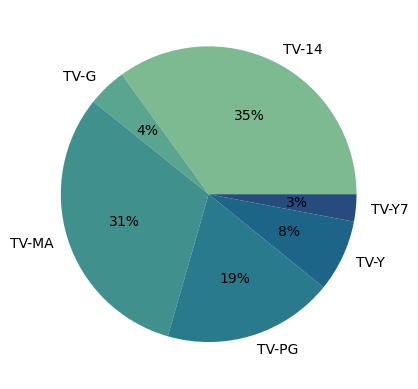

In [20]:
# set up data
rating_overview = df.groupby(['rating']).agg({'rating': 'count'}).rename(columns={'rating': 'Counts'}).reset_index()
# define Seaborn color palette to use 
palette_color = sns.color_palette('crest') 
# plotting data on chart 
plt.pie(rating_overview['Counts'], labels=rating_overview['rating'], colors=palette_color, autopct='%.0f%%') 
# displaying chart 
plt.show()

Display an overview of where most movies belong to. Top 10 countries

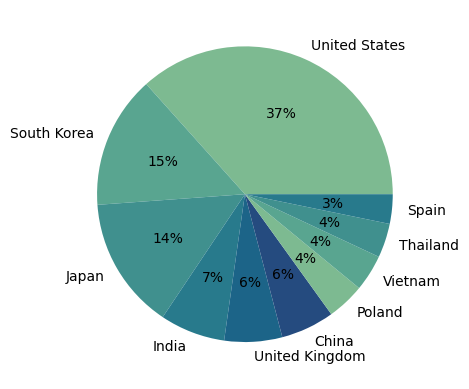

In [21]:
movies_per_country = df.groupby('country').agg({'country':'count'}).rename(columns={'country': 'Counts'}).reset_index().sort_values('Counts', ascending=False)\
.reset_index(drop=True)\
.iloc[:10]
movies_per_country
# define Seaborn color palette to use 
palette_color = sns.color_palette('crest') 
# plotting data on chart 
plt.pie(movies_per_country['Counts'], labels=movies_per_country['country'], colors=palette_color, autopct='%.0f%%') 
# displaying chart 
plt.show() 